# Baselines for SciFact and Citation-Integrity

This notebook has baselines for claim verification on two datasets (SciFact and Citation-Integrity). Baseline predictions are made with different starting checkpoints:
- MultiVers provides the `fever_sci` pre-training checkpoint which is trained on the Fever, EvidenceInference and PubmedQA datasets with shuffled data.
- MultiVers provides fine-tuned models trained on specific target datasets: COVIDFact (`covidfact`), HealthVer (`healthver`), or SciFact (`scifact`).
- Citation-Integrity starts with the `healthver` pre-training checkpoint.
- Citation-Integrity provides a best model (file name: `bestModel-001`) that is labeled here as the `citint` checkpoint. Note: Predictions with this checkpoint are made using code in the `model/multivers-citint` directory because of added tokens for citation markers.

For information on model training, see [the MultiVerS paper](10.48550/arXiv.2112.01640) and [training.md](../doc/training.md).

The second part of this notebook shows:
- Baseline predictions segmented by word count of claims.

Start by importing the necessary packages including the `eval` package from this repo for reading the data and predictions and calculating metrics:

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns

# Get the current directory and parent directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)

# Import eval from the parent directory
import eval

Calculate F1 scores for each combination of checkpoint, dataset, and fold.

In [2]:
# List checkpoints and datasets
datasets = ['scifact', 'scifact', 'scifact', 'citint', 'citint', 'citint']
folds = ['train', 'dev', 'test', 'train', 'dev', 'test']
checkpoints = ['fever_sci', 'healthver', 'scifact', 'citint']
# Get DataFrame of F1 scores
df1 = eval.baseline(datasets, folds, checkpoints, 'f1')

Let's visualize the F1 scores for differen labels and checkpoints.

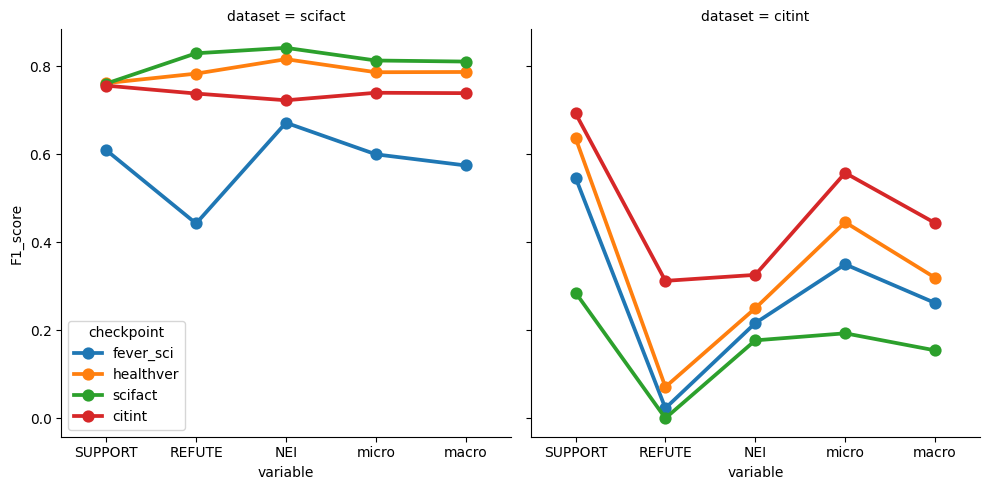

In [3]:
filtered_df1 = df1[df1['fold'] == 'test']
df2 = pd.melt(filtered_df1, id_vars=['metric', 'dataset', 'fold', 'checkpoint'], value_name = 'F1_score')
plot_ = sns.catplot(data=df2, col='dataset', x='variable', y='F1_score', hue='checkpoint', kind='point', legend_out=False)

- We see the increase in F1 score between pre-training and model checkpoints: `fever_sci` and `scifact` on the left and `healthver` and `citint` on the right.
- The model trained on `scifact` performs relatively poorly on `citint` and vice-versa.
- The `scifact` checkpoint shows exceptionally high performance on the SciFact dataset, but only on training and dev folds.

In [4]:
df1[(df1['dataset'] == 'scifact') & (df1['checkpoint'] == 'scifact')]

,metric,dataset,fold,checkpoint,SUPPORT,REFUTE,NEI,micro,macro
12,f1,scifact,train,scifact,1.00000,1.000000,1.000000,1.000000,1.000000
13,f1,scifact,dev,scifact,1.00000,1.000000,1.000000,1.000000,1.000000
14,f1,scifact,test,scifact,0.76087,0.829787,0.842105,0.813333,0.810921


- For Citation-Integrity, better  performance of `healthver` than `fever_sci` is likely related to the [high number of COVID-related statements](http://localhost:8888/notebooks/05_Data-Exploration-for-Citation-Integrity.ipynb#Wordcloud) in Citation-Integrity.
- Very low accuracy for REFUTE and NEI in Citation-Integrity is problematic

**Actions**
- Investigate whether the lower accuracy of predictions for Citation-Integrity than SciFact is due to claim complexity, model hyperparameters, or some other factor.

## Word counts

Let's see how the baselines are affected by numbers of words in the claims.

(4.999, 17.0]    69
(17.0, 21.0]     79
(21.0, 23.0]     46
(23.0, 26.0]     57
(26.0, 29.0]     59
(29.0, 32.0]     58
(32.0, 37.0]     66
(37.0, 43.0]     54
(43.0, 54.0]     60
(54.0, 262.0]    58
Name: count, dtype: int64


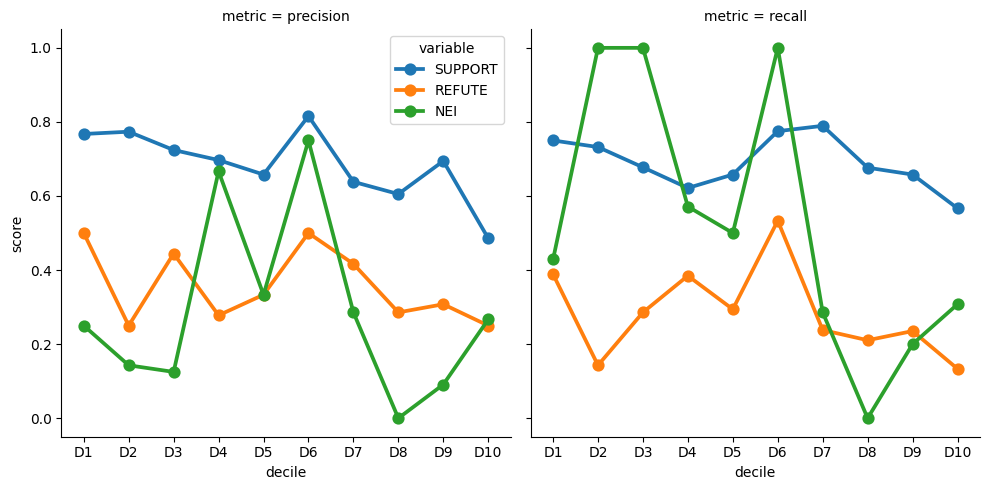

In [5]:
checkpoints = ['citint']
datasets = ['citint']
folds = ['test']

# Run the function once to print the ranges of word lengths and value counts
qcut = eval.baseline(datasets, folds, checkpoints, 'precision', 'D1', return_qcut = True)
print(qcut.value_counts()[qcut.cat.categories])

df3 = pd.DataFrame()
deciles = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10']
for decile in deciles:
    precision_df = eval.baseline(datasets, folds, checkpoints, 'precision', decile)
    precision_df['decile'] = decile
    precision_df.drop(columns = ['micro', 'macro'], inplace=True)
    recall_df = eval.baseline(datasets, folds, checkpoints, 'recall', decile)
    recall_df['decile'] = decile
    recall_df.drop(columns = ['micro', 'macro'], inplace=True)
    df3 = pd.concat([df3, precision_df, recall_df], ignore_index = True)

df4 = pd.melt(df3, id_vars=['metric', 'dataset', 'fold', 'checkpoint', 'decile'], value_name = 'score')
plot_ = sns.catplot(data=df4, col='metric', x='decile', y='score', hue='variable', kind='point', legend_out=False)

Scores are generally lower for the longest claims.
The dependence on word length is strongest for precision of SUPPORT and recall of NEI.

**Action**
- Rewriting claims to 30 words or less is a strategy for improving performance.
- The reasons for perfect recall of NEI for some word count ranges should be investigated.
    - Note that predictions on the `dev` (but not `train`) fold have perfect recall for NEI for the whole Citation-Integrity dataset.